<a href="https://colab.research.google.com/github/kridtapon/QQE-Gravity-Bounce/blob/main/QQE_Gravity_Bounce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.7 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.59
    Uninstalling yfinance-0.2.59:
      Successfully uninstalled yfinance-0.2.59


[*********************100%***********************]  1 of 1 completed


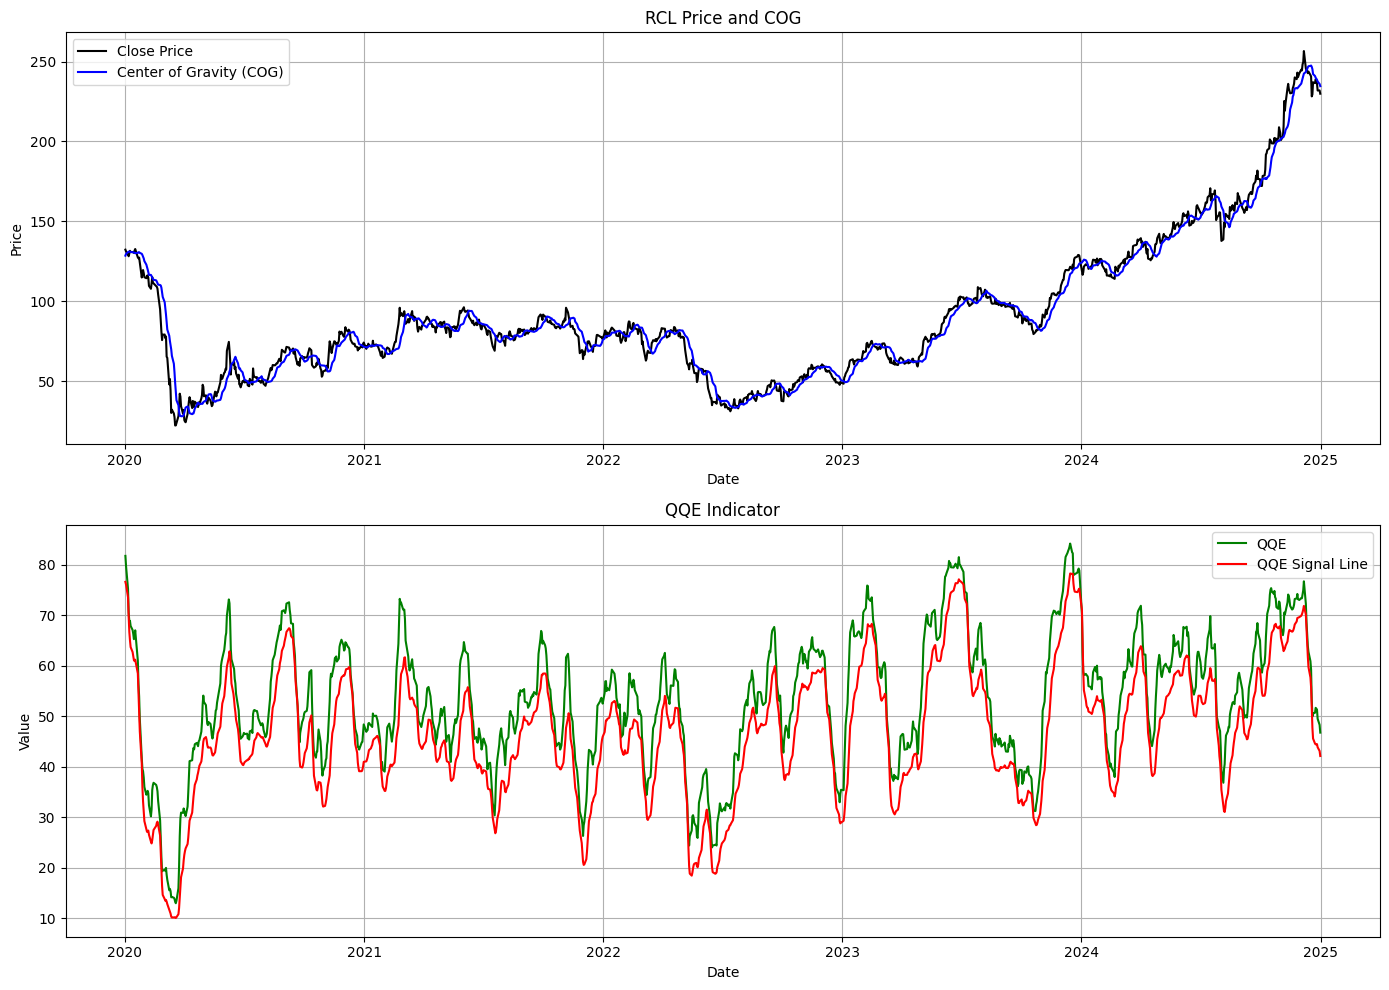

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ========================== Indicator Functions ==========================

def calculate_cog(df, period=10):
    weighted_sum = sum((i + 1) * df['Close'].shift(i) for i in range(period))
    cog = weighted_sum / sum(range(1, period + 1))
    return cog

def calculate_real_qqe_mod(df, rsi_period=14, smoothing_factor=5, wilders_period=14):
    close = df['Close']
    delta = close.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(alpha=1/rsi_period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/rsi_period, adjust=False).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    smoothed_rsi = rsi.ewm(span=smoothing_factor).mean()

    rsi_tr = abs(smoothed_rsi.diff())
    atr_rsi = rsi_tr.ewm(span=wilders_period).mean()

    d_factor = 4.236
    qqe_trailing = smoothed_rsi - (atr_rsi * d_factor)
    signal_line = qqe_trailing.ewm(span=smoothing_factor).mean()

    return smoothed_rsi, signal_line

# ========================== Load Data ==========================

symbol = 'RCL'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# ========================== Compute Indicators ==========================

df['COG'] = calculate_cog(df, period=10)
df['QQE'], df['QQE_Signal'] = calculate_real_qqe_mod(df)

# Filter test period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# ========================== Plotting ==========================

plt.figure(figsize=(14, 10))

# ---- Price and COG ----
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Close Price', color='black')
plt.plot(df.index, df['COG'], label='Center of Gravity (COG)', color='blue')
plt.title(f'{symbol} Price and COG')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# ---- QQE ----
plt.subplot(2, 1, 2)
plt.plot(df.index, df['QQE'], label='QQE', color='green')
plt.plot(df.index, df['QQE_Signal'], label='QQE Signal Line', color='red')
plt.title('QQE Indicator')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# ========================== Indicator Functions ==========================

def calculate_cog(df, period=10):
    weighted_sum = sum((i + 1) * df['Close'].shift(i) for i in range(period))
    cog = weighted_sum / sum(range(1, period + 1))
    return cog

def calculate_real_qqe_mod(df, rsi_period=14, smoothing_factor=5, wilders_period=14):
    """
    Calculate real QQE Mod with volatility trailing and return ATR_RSI for squeeze logic.
    """
    close = df['Close']

    # === RSI Calculation ===
    delta = close.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(alpha=1/rsi_period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/rsi_period, adjust=False).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # === Smoothed RSI ===
    smoothed_rsi = rsi.ewm(span=smoothing_factor).mean()

    # === RSI TR (True Range on RSI) ===
    rsi_tr = abs(smoothed_rsi.diff())
    atr_rsi = rsi_tr.ewm(span=wilders_period).mean()

    # === QQE Line ===
    d_factor = 4.236  # QQE original constant
    qqe_trailing = smoothed_rsi - (atr_rsi * d_factor)
    signal_line = qqe_trailing.ewm(span=smoothing_factor).mean()

    return smoothed_rsi, signal_line, atr_rsi

# ========================== Load Data ==========================

# Define the stock symbol and time period
symbol = 'RCL'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download historical price data
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# ========================== Indicator Calculations ==========================

# Calculate indicators
df['COG'] = calculate_cog(df, period=10)
df['QQE'], df['QQE_Signal'], df['ATR_RSI'] = calculate_real_qqe_mod(df, rsi_period=14, smoothing_factor=5, wilders_period=14)

# ========================== Signal Logic (QQE Squeeze) ==========================

# Define a squeeze as ATR_RSI being low compared to its rolling mean
atr_rsi_rolling_mean = df['ATR_RSI'].rolling(window=20).mean()
squeeze_condition = df['ATR_RSI'] < atr_rsi_rolling_mean * 0.8

# Entry and Exit Condition
df['Entry'] = squeeze_condition & (df['Close'] < df['COG'])
df['Exit'] = (df['Close'] > df['COG']) & (df['QQE'] < df['QQE'].shift(30))

# ========================== Filter Test Period ==========================

df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# ========================== Backtest Setup ==========================

# Shift signals for next-bar execution
shifted_entries = df_test['Entry'].shift(1).fillna(False).astype(bool).to_numpy()
shifted_exits = df_test['Exit'].shift(1).fillna(False).astype(bool).to_numpy()

portfolio = vbt.Portfolio.from_signals(
    close=df_test['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# ========================== Results ==========================

print(portfolio.stats())
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-91a39174f48f>:76: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-13-91a39174f48f>:77: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           130299.517405
Total Return [%]                        30.299517
Benchmark Return [%]                    74.904569
Max Gross Exposure [%]                      100.0
Total Fees Paid                       3378.912685
Max Drawdown [%]                        80.522521
Max Drawdown Duration          1169 days 00:00:00
Total Trades                                   25
Total Closed Trades                            25
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 60.0
Best Trade [%]                          64.691288
Worst Trade [%]                        -63.920792
Avg Winning Trade [%]                   16.386214
Avg Losing Trade [%]                   -13.569461


In [14]:
# Entry and Exit Condition
df['Entry'] = (df['Close'] < df['COG']) & (df['QQE'] > df['QQE'].shift(30))
df['Exit'] = (df['Close'] > df['COG']) & (df['QQE'] < df['QQE'].shift(30))

# Filter test period
df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Shift signals for next-bar execution
shifted_entries = df_test['Entry'].shift(1).fillna(False).astype(bool).to_numpy()
shifted_exits = df_test['Exit'].shift(1).fillna(False).astype(bool).to_numpy()

# ========================== Backtest ==========================

portfolio = vbt.Portfolio.from_signals(
    close=df_test['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# ========================== Results ==========================

print(portfolio.stats())
portfolio.plot().show()

<ipython-input-14-a27ac378617b>:9: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-14-a27ac378617b>:10: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           330654.304152
Total Return [%]                       230.654304
Benchmark Return [%]                    74.904569
Max Gross Exposure [%]                      100.0
Total Fees Paid                       5806.932536
Max Drawdown [%]                        54.565628
Max Drawdown Duration           754 days 00:00:00
Total Trades                                   20
Total Closed Trades                            20
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 60.0
Best Trade [%]                          68.102847
Worst Trade [%]                        -27.316368
Avg Winning Trade [%]                   22.293833
Avg Losing Trade [%]                   -11.918789


In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# ========================== Indicator Functions ==========================

def calculate_cog(df, period=10):
    weighted_sum = sum((i + 1) * df['Close'].shift(i) for i in range(period))
    cog = weighted_sum / sum(range(1, period + 1))
    return cog

def calculate_real_qqe_mod(df, rsi_period=14, smoothing_factor=5, wilders_period=14):
    """
    Calculate real QQE Mod with volatility trailing.
    """
    close = df['Close']

    # === RSI Calculation ===
    delta = close.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(alpha=1/rsi_period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/rsi_period, adjust=False).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # === Smoothed RSI ===
    smoothed_rsi = rsi.ewm(span=smoothing_factor).mean()

    # === RSI TR (True Range on RSI) ===
    rsi_tr = abs(smoothed_rsi.diff())
    atr_rsi = rsi_tr.ewm(span=wilders_period).mean()

    # === QQE Line ===
    d_factor = 4.236  # QQE original constant
    qqe_trailing = smoothed_rsi - (atr_rsi * d_factor)
    signal_line = qqe_trailing.ewm(span=smoothing_factor).mean()

    return smoothed_rsi, signal_line

# ========================== Load Data ==========================

# Define the stock symbol and time period
symbol = 'RCL'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download historical price data
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# ========================== Indicator Calculations ==========================

# Calculate indicators
df['COG'] = calculate_cog(df, period=10)
df['QQE'], df['QQE_Signal'] = calculate_real_qqe_mod(df, rsi_period=14, smoothing_factor=5, wilders_period=14)

# ========================== Signal Logic ==========================

# Buy when price is below COG and QQE crosses above its signal
df['Entry'] = (df['Close'] < df['COG']) & (df['QQE'] > df['QQE'].shift(30))

# Sell when price is above COG and QQE crosses below its signal
df['Exit'] = (df['Close'] > df['COG']) & (df['QQE'] < df['QQE'].shift(30))

# Filter test period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Shift signals for next-bar execution
shifted_entries = df['Entry'].shift(1).fillna(False).astype(bool).to_numpy()
shifted_exits = df['Exit'].shift(1).fillna(False).astype(bool).to_numpy()

# ========================== Backtest ==========================

portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# ========================== Results ==========================

print(portfolio.stats())
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-6-70fb685de4c6>:71: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-6-70fb685de4c6>:72: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           330654.304152
Total Return [%]                       230.654304
Benchmark Return [%]                    74.904569
Max Gross Exposure [%]                      100.0
Total Fees Paid                       5806.932536
Max Drawdown [%]                        54.565628
Max Drawdown Duration           754 days 00:00:00
Total Trades                                   20
Total Closed Trades                            20
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 60.0
Best Trade [%]                          68.102847
Worst Trade [%]                        -27.316368
Avg Winning Trade [%]                   22.293833
Avg Losing Trade [%]                   -11.918789


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# ========================== Indicator Functions ==========================

def calculate_cog(df, period=10):
    weighted_sum = sum((i + 1) * df['Close'].shift(i) for i in range(period))
    cog = weighted_sum / sum(range(1, period + 1))
    return cog

def calculate_real_qqe_mod(df, rsi_period=14, smoothing_factor=5, wilders_period=14):
    """
    Calculate real QQE Mod with volatility trailing.
    """
    close = df['Close']

    # === RSI Calculation ===
    delta = close.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(alpha=1/rsi_period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/rsi_period, adjust=False).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # === Smoothed RSI ===
    smoothed_rsi = rsi.ewm(span=smoothing_factor).mean()

    # === RSI TR (True Range on RSI) ===
    rsi_tr = abs(smoothed_rsi.diff())
    atr_rsi = rsi_tr.ewm(span=wilders_period).mean()

    # === QQE Line ===
    d_factor = 4.236  # QQE original constant
    qqe_trailing = smoothed_rsi - (atr_rsi * d_factor)
    signal_line = qqe_trailing.ewm(span=smoothing_factor).mean()

    return smoothed_rsi, signal_line

# ========================== Load Data ==========================

# Define the stock symbol and time period
symbol = 'APO'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download historical price data
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# ========================== Indicator Calculations ==========================

# Calculate indicators
df['COG'] = calculate_cog(df, period=10)
df['QQE'], df['QQE_Signal'] = calculate_real_qqe_mod(df, rsi_period=14, smoothing_factor=5, wilders_period=14)

# ========================== Signal Logic ==========================

# Buy when price is below COG and QQE crosses above its signal
df['Entry'] = (df['Close'] < df['COG']) & (df['QQE'] > df['QQE'].shift(30))

# Sell when price is above COG and QQE crosses below its signal
df['Exit'] = (df['Close'] > df['COG']) & (df['QQE'] < df['QQE'].shift(30))

# Filter test period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Shift signals for next-bar execution
shifted_entries = df['Entry'].shift(1).fillna(False).astype(bool).to_numpy()
shifted_exits = df['Exit'].shift(1).fillna(False).astype(bool).to_numpy()

# ========================== Backtest ==========================

portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# ========================== Results ==========================

print(portfolio.stats())
portfolio.plot().show()